In [1]:
"""
Liu et al., "Deep Supervised Hashing for Fast Image Retrieval"
"""
from collections import defaultdict
import random
import torch
from torch import nn
from torch import optim
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from model import LiuDSH

#-----------------------------------

# hyper-parameters
DATA_ROOT = 'data_out'
# LR_INIT = 3e-4
# BATCH_SIZE = 128
# EPOCH = 40
# NUM_WORKERS = 16
CODE_SIZE = 16  # bits
# MARGIN = 16
# ALPHA = 0.01  # TODO: adjust
PERCENT_DATA_TAKING = 0.1
model_name = 'model_0.1_16_20_0.01_32_20230816-195338.pt'
'''
    model_0.1_8_20_0.005_16_20230816-211230.pt = 0.7305
    model_0.1_8_20_0.01_16_20230816-193350.pt = 0.7184

    model_0.1_12_20_0.005_24_20230816-220452.pt = 0.7650
    model_0.1_12_20_0.01_24_20230816-215401.pt = 0.7576

    model_0.1_16_20_0.005_32_20230816-210026.pt = 0.7744
    model_0.1_16_20_0.01_32_20230816-195338.pt = 0.7801

    model_0.1_24_20_0.005_48_20230816-213322.pt = 
    model_0.1_24_20_0.01_48_20230816-214353.pt = 

'''

#-----------------------------------


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.set_default_dtype(torch.float)

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307, ), std=(0.3081, )),
])

train_dataset = FashionMNIST(root=DATA_ROOT, train=True, transform=mnist_transform, download=True)
train_dataset = Subset(train_dataset, range(int(len(train_dataset)*PERCENT_DATA_TAKING)))
print(f'Train set size: {len(train_dataset)}')

val_dataset = FashionMNIST(root=DATA_ROOT, train=False, transform=mnist_transform, download=True)
val_dataset = Subset(val_dataset, range(int(len(val_dataset)*PERCENT_DATA_TAKING)))
print(f'Val set size: {len(val_dataset)}')

# train_dataloader = DataLoader(
#     train_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     drop_last=False,
#     num_workers=NUM_WORKERS)

# val_dataloader = DataLoader(
#     val_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     drop_last=False,
#     num_workers=NUM_WORKERS)

class HashTable:
    def __init__(self, hash_size, model):
        self.table = {}
        self.hash_size = hash_size
        self.table_size = 1 << hash_size
        self.model = model

    def bool2int(self, x):
        y = 0
        for i, j in enumerate(x):
            if j:
                y += 1 << i
        return y
        
    def getHash(self, image):
        hash = model(torch.Tensor(np.array([image])))
        hash = torch.round(hash.clamp(-1, 1) * 0.5 + 0.5)
        return self.bool2int(hash[0])

    def add(self, id, image, label):
        entry = {"id_label": str(id) + "_" + str(label)}
        hash = self.getHash(image)
        if hash in self.table:
            self.table[hash].append(entry)
        else:
            self.table[hash] = [entry]
    
    def hamming_distance(self, x, y):
        z = x ^ y
        return z.bit_count()

    def query(self, image, k=1):
        hash = self.getHash(image)
        hvals = sorted(np.arange(self.table_size), key=lambda x: self.hamming_distance(hash, x))
        entrys = []
        for h in hvals:
            if h not in self.table:
                continue
            if len(entrys) + len(self.table[h]) <= k:
                entrys.extend(self.table[h])
            else:
                entrys.extend(self.table[h][:(k-len(entrys))])
            if len(entrys) == k:
                break
        return entrys
        
def average_precision_at_k(true_positives, k):
    precision_sum = 0
    relevant_count = 0

    for i in range(k):
        if true_positives[i]:
            relevant_count += 1
            precision = relevant_count / (i + 1)
            precision_sum += precision

    if relevant_count == 0:
        return 0

    average_precision = precision_sum / relevant_count
    return average_precision

def mean_average_precision_at_k(true_labels, k):
    num_queries = len(true_labels)
    map_sum = 0

    for i in range(num_queries):
        true_label = true_labels[i]
        true_positives = [label == 1 for label in true_label]

        ap_at_k = average_precision_at_k(true_positives, k)
        map_sum += ap_at_k

    mean_average_precision = map_sum / num_queries
    return mean_average_precision

if __name__ == '__main__':  
    model = torch.load(model_name)
    model.eval()

    CODE_SIZE = int(model_name.split('_')[2])
    print(CODE_SIZE)

    hash_table = HashTable(CODE_SIZE, model)
    for id, (image, label) in enumerate(train_dataset):
        hash_table.add(id, image, label)

    # y_true = []
    # y_pred = []
    # true_labels = []
    # k = 10
    # for id, (image, label) in enumerate(val_dataset):
    #     y_true.append(label)
    #     entrys = hash_table.query(image, k=k)
    #     y = []
    #     for r in entrys:
    #         image_id, la = r['id_label'].split("_")[0], r['id_label'].split("_")[1]
    #         y.append(int(la))
    #     y_pred.append(y)
    #     true_positives = [x == label for x in y]
    #     while len(true_positives) < k:
    #         true_positives.append(1)
    #     true_labels.append(true_positives)
    #     print(label, y, true_positives)


    # map = mean_average_precision_at_k(true_labels, k)
    # print(map)


Train set size: 6000
Val set size: 1000
16


(6000, 28, 28) (6000,)


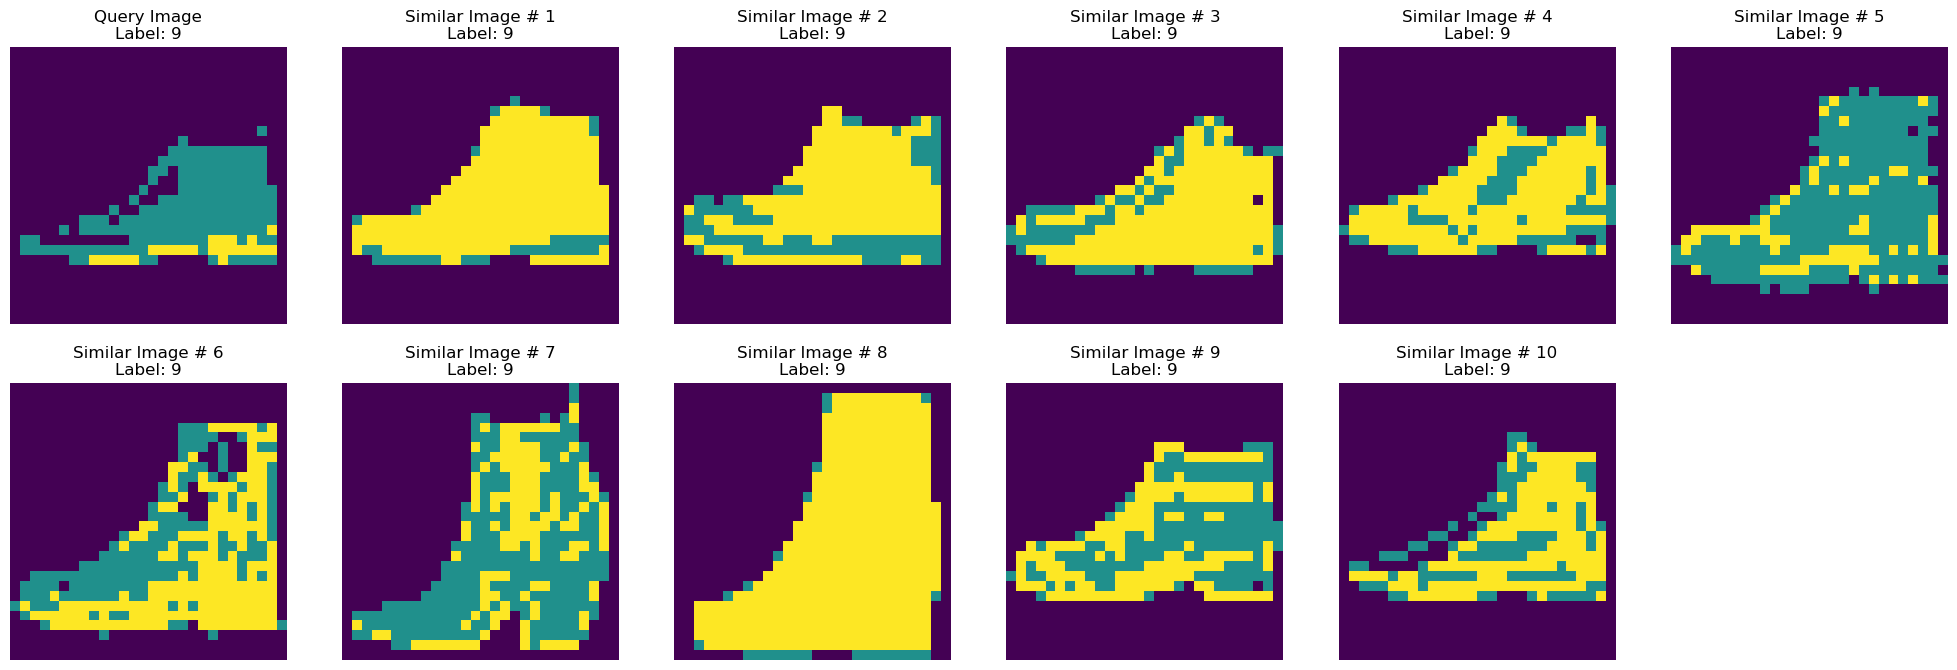

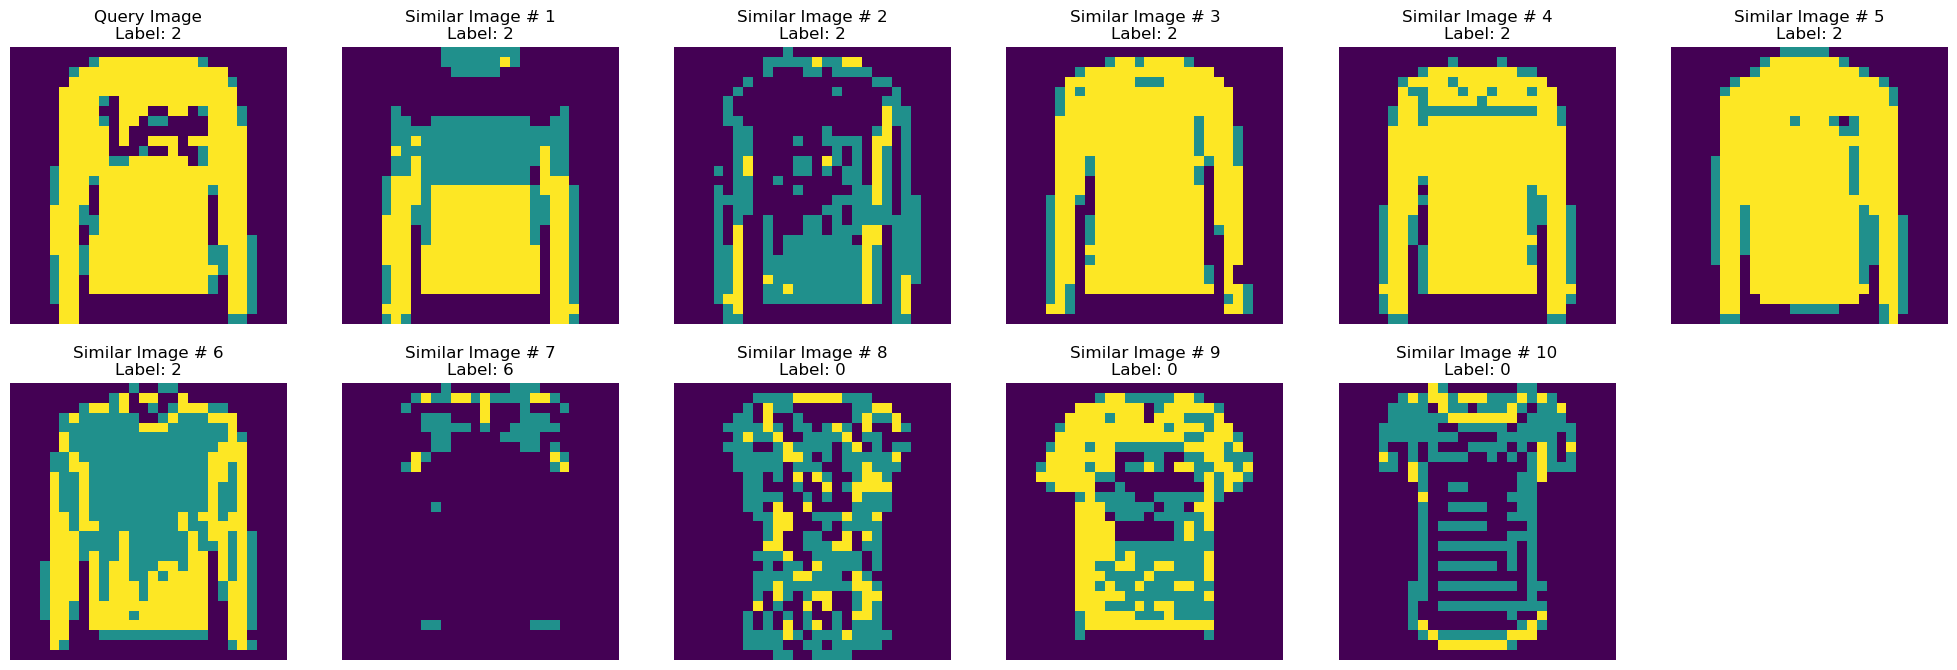

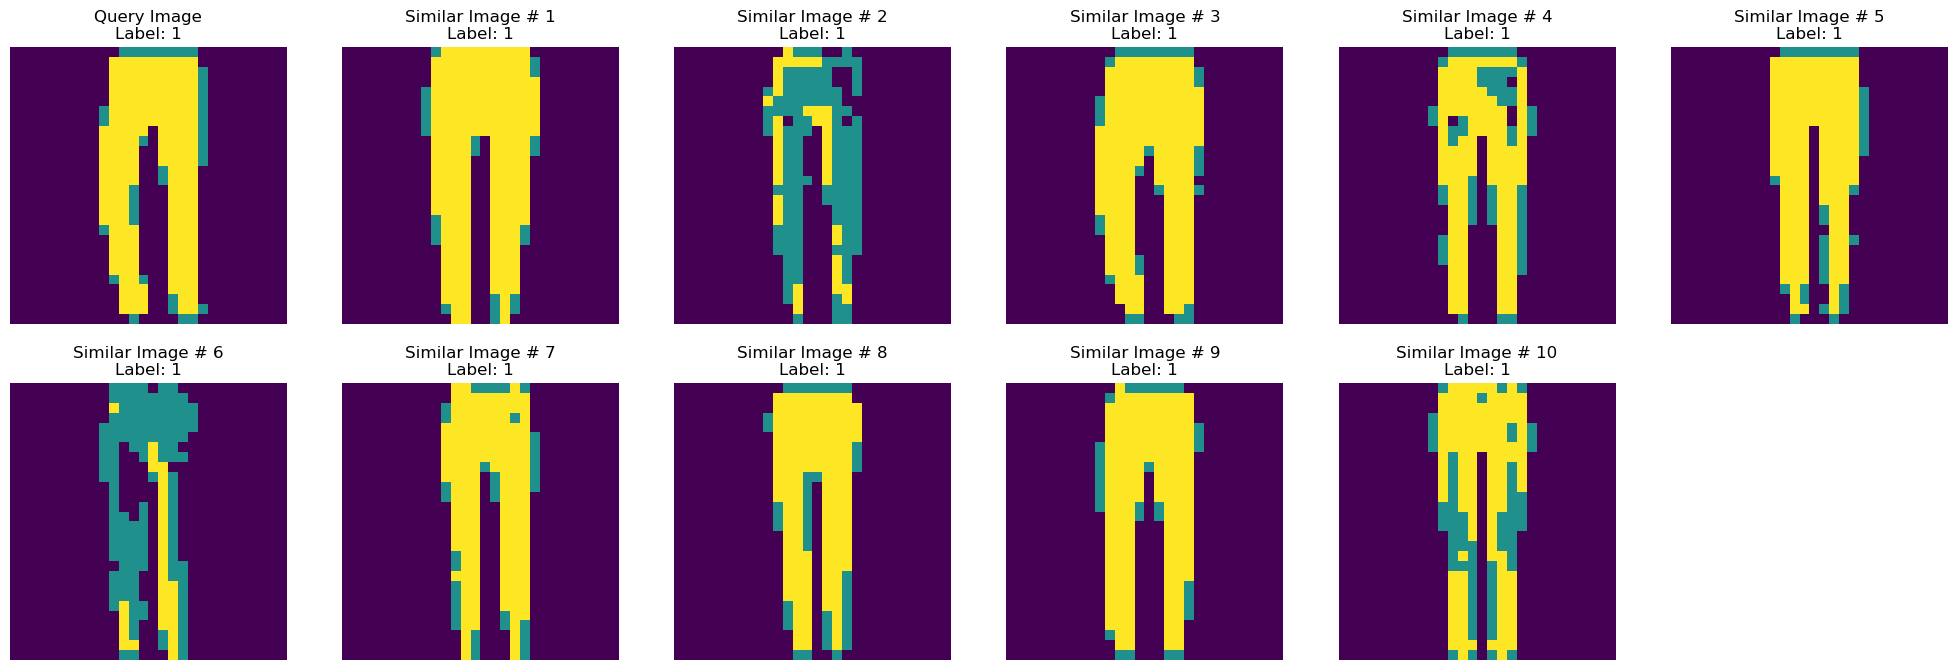

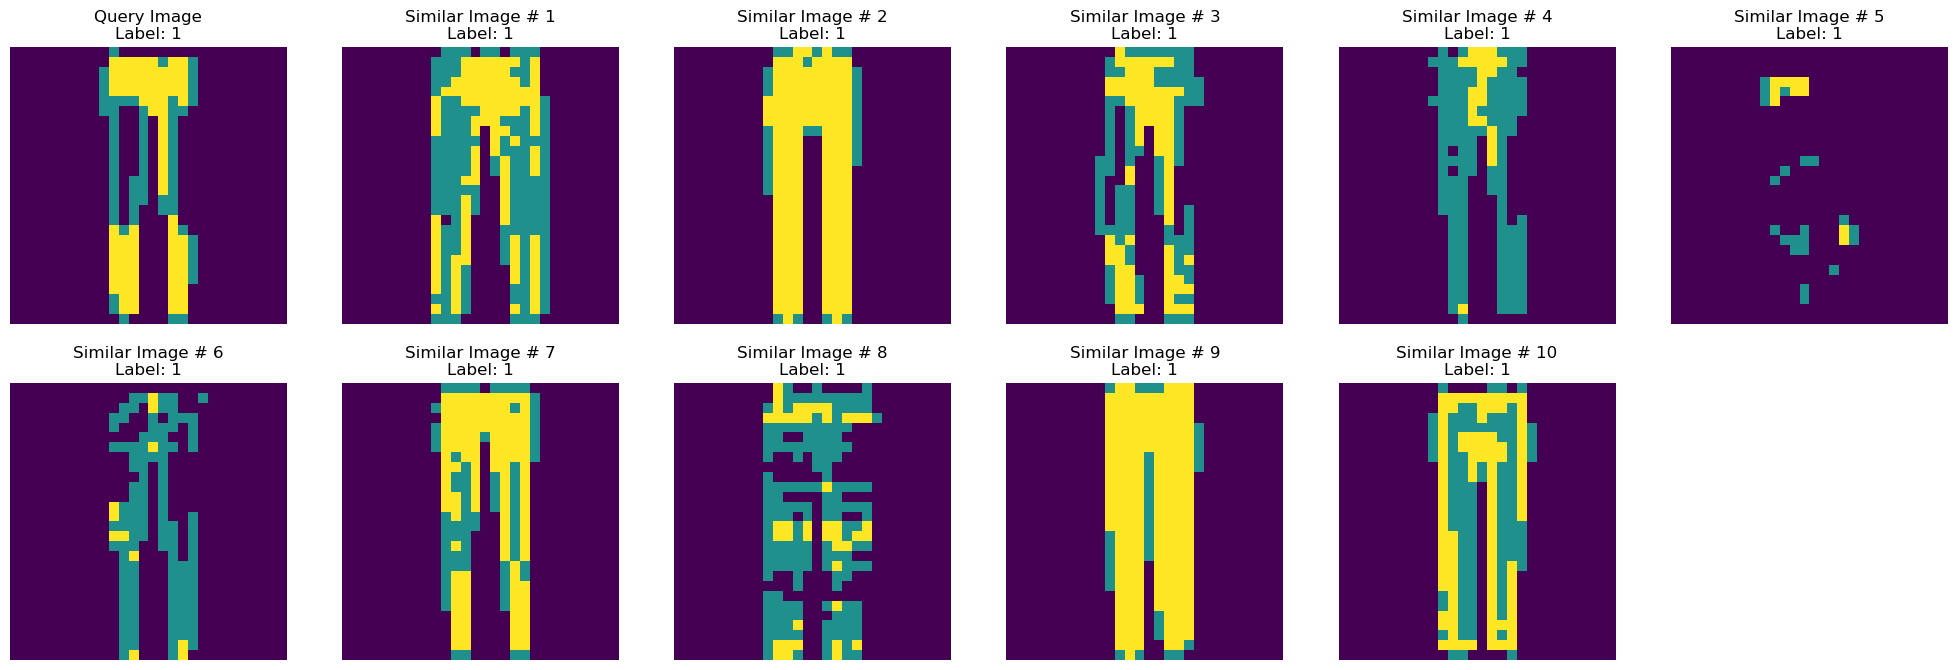

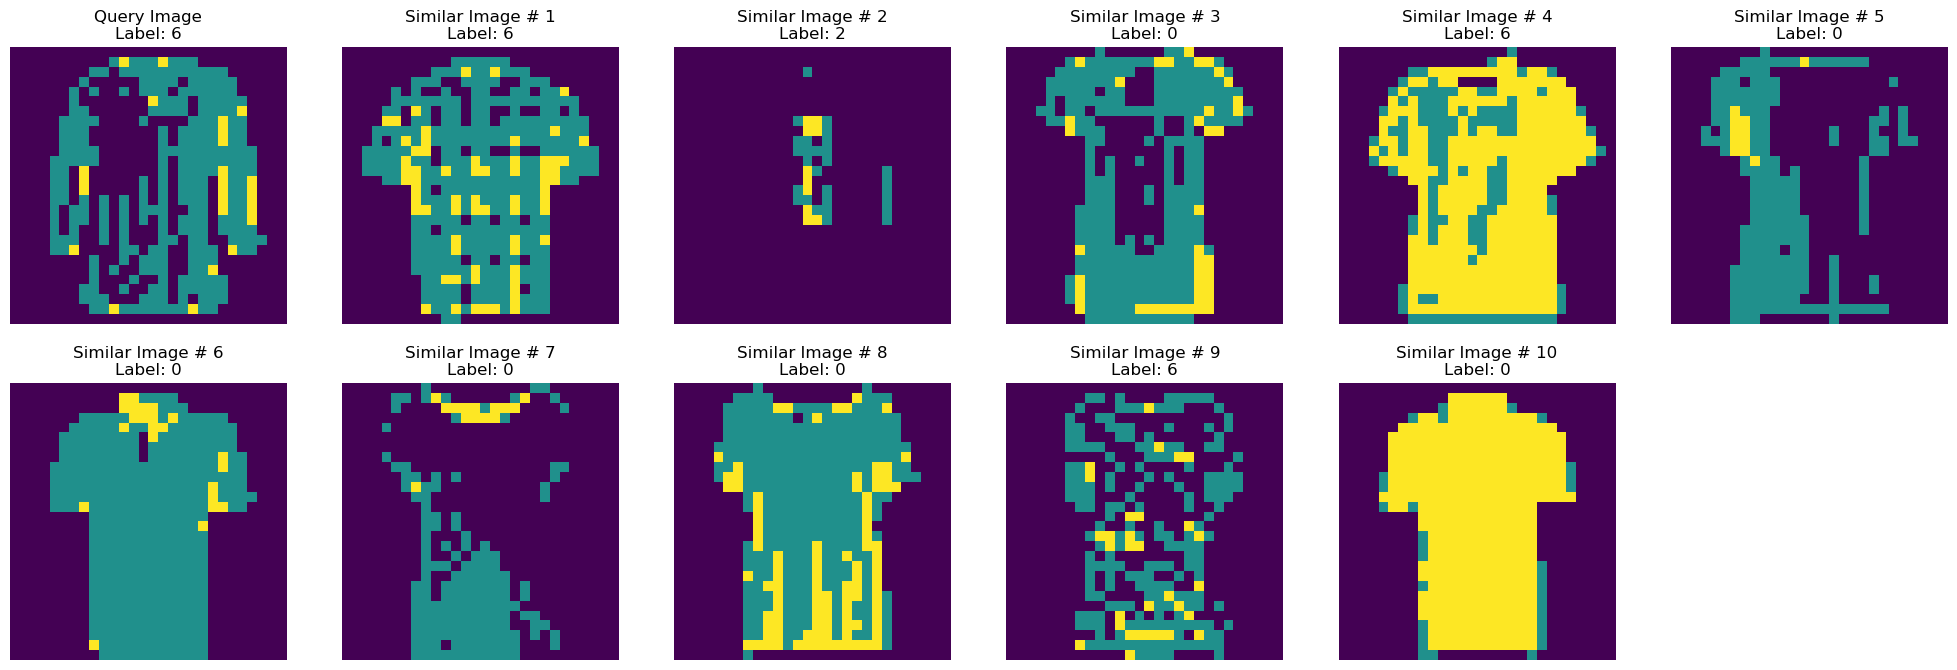

In [17]:
import matplotlib.pyplot as plt

def plot_images(images, labels):
    plt.figure(figsize=(25, 8))
    columns = 6
    for (i, image) in enumerate(images):
        ax = plt.subplot(len(images) // columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(labels[i]))
        else:
            ax.set_title("Similar Image # " + str(i) + "\nLabel: {}".format(labels[i]))
        plt.imshow(image.astype("int"))
        plt.axis("off")

images = []
labels = []

for image, label in train_dataset:
    images.append(image[0].numpy())
    labels.append(label)

images = np.array(images)
labels = np.array(labels)
print(images.shape, labels.shape)

k = 10
idx = 0

for id, (image, label) in enumerate(val_dataset):
    entrys = hash_table.query(image, k=k)
    imgs = [image[0].numpy()]
    labs = [label]
    for r in entrys:
        image_id, la = r['id_label'].split("_")[0], r['id_label'].split("_")[1]
        imgs.append(images[int(image_id)])
        labs.append(la)

    plot_images(imgs, labs)

    idx += 1
    if idx == 5: 
        break
